# Bootstrapping Yield Curve from T-Bonds

## Loading Data

In [45]:
#Importing all the necessary libraries

import numpy as np
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import datetime
import collections
import requests
from bs4 import BeautifulSoup
import json

In [46]:
#defining a custom function to scrape required data from https://www.wsj.com/market-data/bonds/treasuries

def scrape_data():
    #The function is specifically written for scraping treasury notes prices
    #data from wsj.com website
    mostActiveStocksUrl = "https://www.wsj.com/market-data/bonds/treasuries"
    page = requests.get(mostActiveStocksUrl, headers={'User-Agent': 'Custom'})
    data = page.text
    soup = BeautifulSoup(page.content, 'html.parser')
    rows = soup.find_all('script') # we get all the script tags
    importantJson = ''

    for r in rows:
        text = r.text
        if 'mdc_treasury_' in text: # the scirpt tags containing the date,
            importantJson = text
            break

    importantJson = importantJson\
        .replace('window.__STATE__ =', '')\
        .replace(';', '')\
        .strip()

    jsn = json.loads(importantJson)
    df_data = pd.json_normalize(jsn['data']['mdc_treasury_{\"treasury\":\"NOTES_AND_BONDS\"}']['data']['data']['instruments'])
    
    #re-order the columns of the extracted data to match the order of data
    #reflected in the website
    cols = ['maturityDate','coupon','bid','ask','change','askYield']
    df_data = df_data[cols]
    
    #Change the names of the columns of the extracted data to match the names that are 
    #reflected in the website
    df_data.columns = ['MATURITY','COUPON', 'BID', 'ASKED', 'CHG', 'ASKED YIELD']
    
    #filter data to remove NA values
    df_data = df_data[df_data['BID'] != "n.a."]
    
    #Change the type of variables of Maturity date to pandas datetime and coupon, bid and asked
    #price to numeric
    df_data['MATURITY'] = pd.to_datetime(df_data['MATURITY'].astype(str))
    df_data[['COUPON', 'BID', 'ASKED']] = df_data[['COUPON', 'BID', 'ASKED']].apply(pd.to_numeric)
    df_data = df_data[df_data['BID'] != 0]
    #df_data.set_index("maturityDate", inplace=True)
    #df_data.index = pd.to_datetime(df_data.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
    return df_data

In [47]:
#swap rate used to construct dummy prices
swaprate_15Y = 0.00768

In [48]:
#Running the scrape_data() function created above and storing the data in a variable
TBond_data = scrape_data()

In [5]:
#Back-up of copying the data to python through csv files in case web scraping doesn't work

#TBond_data = pd.read_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/WSJ T-Bond Data.csv")
#TBond_data['MATURITY'] = pd.to_datetime(TBond_data['MATURITY'].astype(str))
#TBond_data = TBond_data[TBond_data['MATURITY'].dt.day == 15] 

In [6]:
TBond_data.shape

(313, 6)

In [7]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
1,2020-09-30,1.375,100.014,100.020,unch.,-0.2570
2,2020-09-30,2.000,100.022,100.026,-0.0020,-0.2440
3,2020-09-30,2.750,100.030,100.034,-0.0020,-0.108
4,2020-10-15,1.625,100.034,100.040,-0.0060,0.047
5,2020-10-31,1.375,100.050,100.054,unch.,-0.030


In [8]:
TBond_data.tail()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
309,2049-08-15,2.250,119.262,119.282,-0.8340,1.410
310,2049-11-15,2.375,122.306,123.006,-0.8680,1.409
311,2050-02-15,2.000,114.004,114.024,-0.1560,1.413
312,2050-05-15,1.250,95.206,95.226,-0.8280,1.428
313,2050-08-15,1.375,98.224,98.244,-0.8420,1.426


## Computing Accrued Interest

In [9]:
#Getting today's date
#Also get the spot settlement day by T+1 adjustment
spot_conv = 1 #2 for some markets
date0 = date.today()
date0 = pd.to_datetime(date0)
settle_date = date0 + pd.Timedelta(days = spot_conv)

In [10]:
#Defining a custom function that returns the coupon payment dates of a 30 Year bond based on the maturity date of the bond
def cpn_schedule(maturity):
    #construct the past 60 coupon payment dates from the maturity date of the bond
    cpn_dates = np.empty(61, dtype=object)    
    for i in range(1,62):
        if(maturity.day == 15):
            cpn_dates[-i] = maturity + relativedelta(months=-(i-1)*6)
        else:    
            #forcing the coupon payment dates to month-end dates
            cpn_dates[-i] = maturity + relativedelta(months=-(i-1)*6) + relativedelta(day=31)    
    return cpn_dates 

In [11]:
#Defining a custom function that calculates Accrued Interest from the coupon rate, today's date and the maturity date of the bond
def Accr_Int(cpn, date0, maturity):
    #Create the coupon payment schedule from the maturity date of bond
    cpn_schd = cpn_schedule(maturity)
    #if valuation date coincides with maturity of the bonds
    if (date0 == maturity):
        return cpn
    #if coupon payment date matches the date of valuation
    elif (cpn_schd[np.searchsorted(cpn_schd, date0)] == date0):
        prev_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0)]
        next_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0) + 1]
    #if valuation date lies between coupon payment dates
    else:
        prev_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0) - 1]
        next_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0)]
    
    acc_int = 0.5 * cpn * (date0 - prev_cpn_date)/(next_cpn_date - prev_cpn_date)
    
    return acc_int

In [12]:
#Creating a column in the dataframe for accrued interest and populating it by running the custom function defined bove
TBond_data['ACCR_INT'] = np.nan

for i in range(len(TBond_data)):
    TBond_data.iloc[i,6] = Accr_Int(TBond_data.iloc[i,1], settle_date, TBond_data.iloc[i,0])

In [13]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT
1,2020-09-30,1.375,100.014,100.020,unch.,-0.2570,0.638661
2,2020-09-30,2.000,100.022,100.026,-0.0020,-0.2440,0.928962
3,2020-09-30,2.750,100.030,100.034,-0.0020,-0.108,1.277322
4,2020-10-15,1.625,100.034,100.040,-0.0060,0.047,0.688183
5,2020-10-31,1.375,100.050,100.054,unch.,-0.030,0.523098


## Computing Dirty Price

In [14]:
# Dirty Price = Clean Price + Accrued Interest
TBond_data['DIRTY_PRICE'] = TBond_data['ASKED'] + TBond_data['ACCR_INT']

In [15]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT,DIRTY_PRICE
1,2020-09-30,1.375,100.014,100.020,unch.,-0.2570,0.638661,100.658661
2,2020-09-30,2.000,100.022,100.026,-0.0020,-0.2440,0.928962,100.954962
3,2020-09-30,2.750,100.030,100.034,-0.0020,-0.108,1.277322,101.311322
4,2020-10-15,1.625,100.034,100.040,-0.0060,0.047,0.688183,100.728183
5,2020-10-31,1.375,100.050,100.054,unch.,-0.030,0.523098,100.577098


In [16]:
TBond_data.tail()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT,DIRTY_PRICE
309,2049-08-15,2.250,119.262,119.282,-0.8340,1.410,0.201766,119.483766
310,2049-11-15,2.375,122.306,123.006,-0.8680,1.409,0.806726,123.812726
311,2050-02-15,2.000,114.004,114.024,-0.1560,1.413,0.179348,114.203348
312,2050-05-15,1.250,95.206,95.226,-0.8280,1.428,0.424592,95.650592
313,2050-08-15,1.375,98.224,98.244,-0.8420,1.426,0.123302,98.367302


## Matrix Formulations

In [17]:
#Creating an list of all the dates on which cashflows will occur 
#if we hold a portfolio consisting of one of all the bonds listed in the data

Alldates = np.empty(0)

for i in range(len(TBond_data)):
    Alldates = np.hstack((Alldates, cpn_schedule(TBond_data.iloc[i,0])))
    
#Filter out the dates that are older than the valuation date as these dates
#are not required for valuation    
Alldates = np.unique(Alldates)
Alldates = Alldates[settle_date < Alldates]

## Creation of a Price Matrix

In [18]:
#Remove all the columns not needed for computation of the discount rates
TBond_data_f = TBond_data.drop(['BID','ASKED','CHG','ASKED YIELD','ACCR_INT'], axis = 1)
#Add a column to the filtered dataframe representing the Principal value of the bond
TBond_data_f['PRINCIPAL'] = 100

In [19]:
TBond_data_f.head()

,MATURITY,COUPON,DIRTY_PRICE,PRINCIPAL
1,2020-09-30,1.375,100.658661,100
2,2020-09-30,2.000,100.954962,100
3,2020-09-30,2.750,101.311322,100
4,2020-10-15,1.625,100.728183,100
5,2020-10-31,1.375,100.577098,100


In [20]:
#Create dummy prices for dates with missing bond prices
missed_dates = np.setdiff1d(Alldates.astype(np.datetime64), TBond_data_f['MATURITY'].values)
dummy_prices = pd.DataFrame(missed_dates, columns = ['MATURITY'])
dummy_prices['COUPON'] = 0
dummy_prices['DIRTY_PRICE'] = 100 * np.exp(-1*swaprate_15Y*(np.array((dummy_prices['MATURITY'] - date0).dt.days)/365.25)) 
dummy_prices['PRINCIPAL'] = 100

In [21]:
dummy_prices

,MATURITY,COUPON,DIRTY_PRICE,PRINCIPAL
0,2030-11-15,0,92.491717,100
1,2031-05-15,0,92.140378,100
2,2031-08-15,0,91.962309,100
3,2031-11-15,0,91.784584,100
4,2032-02-15,0,91.607203,100
5,2032-05-15,0,91.434009,100
6,2032-08-15,0,91.257305,100
7,2032-11-15,0,91.080942,100
8,2033-02-15,0,90.904920,100
9,2033-05-15,0,90.734962,100


In [22]:
TBond_data_f = pd.concat([TBond_data_f, dummy_prices], axis=0)

In [23]:
#Aggregate the price, coupon and Principal data for bonds maturing on the same date
#to create an aggregate security capturing all the discount factors that are reflected
#by the bonds maturity on that particular maturity date
Agg_Bond_data = TBond_data_f.groupby([TBond_data_f['MATURITY'].dt.date]).sum()

In [24]:
#Store the values in Price_matrix
Price_matrix = Agg_Bond_data

In [25]:
Price_matrix.head()

,COUPON,DIRTY_PRICE,PRINCIPAL
MATURITY,,,
2020-09-30,6.125,302.924945,300
2020-10-15,1.625,100.728183,100
2020-10-31,6.000,302.520609,300
2020-11-15,4.375,201.714073,200
2020-11-30,6.375,302.308566,300


In [26]:
Price_matrix.tail()

,COUPON,DIRTY_PRICE,PRINCIPAL
MATURITY,,,
2049-08-15,2.250,119.483766,100
2049-11-15,2.375,123.812726,100
2050-02-15,2.000,114.203348,100
2050-05-15,1.250,95.650592,100
2050-08-15,1.375,98.367302,100


## Generating the CF matrix

In [27]:
#Create a matrix of all the dates when cashflows occur
#for all the bonds present in the WSJ data
CF = pd.DataFrame(columns=Alldates)
CF = CF.T
CF.head()

""
2020-09-30
2020-10-15
2020-10-31
2020-11-15
2020-11-30


In [28]:
for i in range(len(Price_matrix)):
    #generate coupon payment schedule for all the bonds in Price matrix iteratively 
    #and fill the Cashflows matrix with cashflows of all the bonds
    cpn_dates = cpn_schedule(Price_matrix.iloc[i,:].name)[settle_date <= cpn_schedule(Price_matrix.iloc[i,:].name)].astype("datetime64[ns]")

    cpns = np.empty(len(cpn_dates)); cpns.fill(0.5*Price_matrix.iloc[i,:].COUPON)
    if (Price_matrix.iloc[i,:].DIRTY_PRICE != 0):
        cpns[-1] = cpns[-1] + Price_matrix.iloc[i,:].PRINCIPAL
    
    cpn_pmts = pd.DataFrame(cpns, index = cpn_dates)
    CF = pd.concat([CF,cpn_pmts], axis=1)

In [29]:
CF = CF.T
CF = CF.fillna(0)

In [30]:
CF.shape

(228, 228)

In [31]:
CF.head()

,2020-09-30,2020-10-15,2020-10-31,2020-11-15,2020-11-30,2020-12-15,2020-12-31,2021-01-15,2021-01-31,2021-02-15,...,2048-05-15,2048-08-15,2048-11-15,2049-02-15,2049-05-15,2049-08-15,2049-11-15,2050-02-15,2050-05-15,2050-08-15
0,303.0625,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,100.8125,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,303.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0,202.1875,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0,0.0000,303.1875,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Computing the discounting factor matrix

In [32]:
#Compute the vector of discount factors by matrix multiplication of 
#inverse of the Cashflows matrix and Dirty prices of the bonds
d = np.matmul(np.linalg.inv(CF.values),Price_matrix['DIRTY_PRICE'].values)

In [34]:
#Discount Factors
d

array([0.99954612, 0.99916363, 0.99841785, 0.99765848, 0.99710102,
       0.99692936, 0.99571964, 0.99556263, 0.9949525 , 0.99630474,
       0.99641249, 0.99869175, 0.9968896 , 0.99736923, 0.99560455,
       0.99505508, 0.99560017, 0.99341849, 0.99564858, 0.99863142,
       0.9941976 , 0.99569259, 0.99423938, 0.99468303, 0.99755188,
       0.99227148, 0.9966408 , 0.99762989, 0.99471019, 0.99784181,
       0.99418305, 0.99741274, 0.99386964, 0.99497423, 0.99518567,
       0.9957553 , 0.9945495 , 0.99576231, 0.99244103, 0.99453765,
       0.99171315, 0.99226555, 0.99225031, 0.99123362, 0.99372748,
       0.99318436, 0.99233267, 0.9925602 , 0.99456931, 0.99341943,
       0.99180648, 0.99624146, 0.99655944, 0.99488883, 0.99346214,
       0.99582868, 0.99321746, 0.99195334, 0.99537885, 0.99049716,
       0.99183025, 0.99451312, 0.99078224, 0.99215471, 0.9928637 ,
       0.9940803 , 0.99175331, 0.98944732, 0.99392975, 0.99046971,
       0.99144458, 0.98918105, 0.99232308, 0.99191667, 0.99404

In [35]:
#Convert the discount factors into annualized continuous interest rates
mat_times = (CF.columns - settle_date).days/365.25
d_mod = -1*np.log(d)/mat_times

In [37]:
#Construct a dataframe with dates and discount rates
disc_rates = pd.DataFrame(d_mod, index = CF.columns, columns = (['Rates']))
disc_rates.replace([np.inf, -np.inf], np.nan)

,Rates
2020-09-30,0.012755
2020-10-15,0.010915
2020-10-31,0.013144
2020-11-15,0.014513
2020-11-30,0.014330
...,...
2049-08-15,0.015486
2049-11-15,0.015229
2050-02-15,0.015087
2050-05-15,0.015130


## Plot Maturity Date vs Discount Rates

Text(0, 0.5, 'Discount rate')

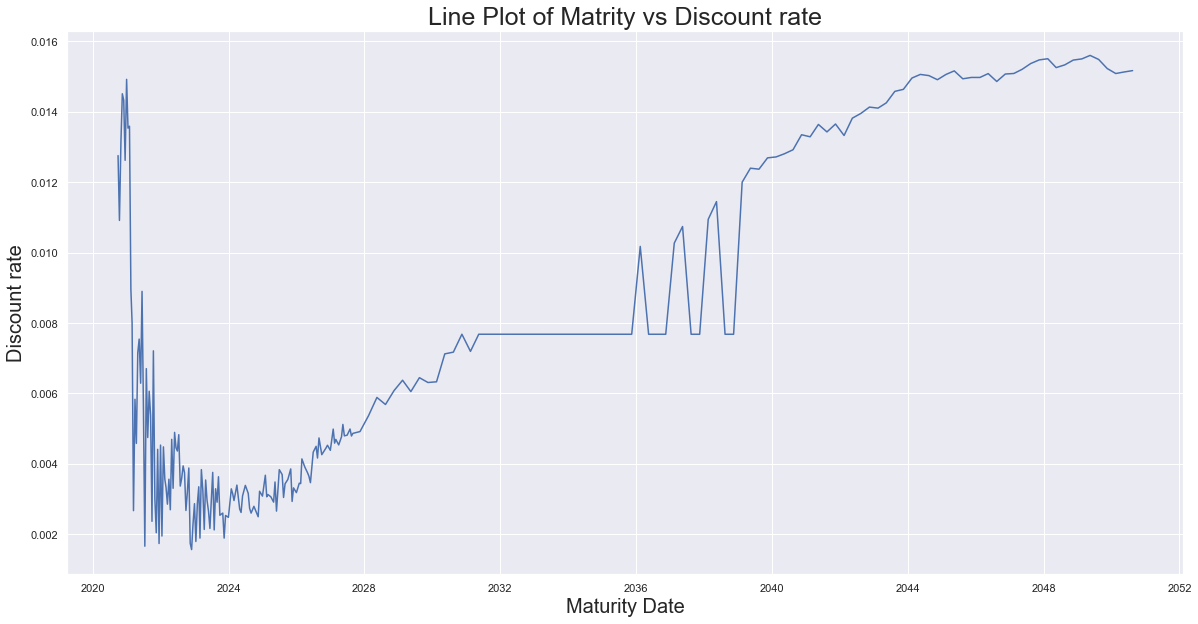

In [38]:
#Line plot of dates vs discount rates
plt.figure(figsize=(20,10))
plt.plot(disc_rates.index,disc_rates.Rates)
plt.title('Line Plot of Matrity vs Discount rate', fontsize = 25)
plt.xlabel('Maturity Date', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)

Text(0, 0.5, 'Discount rate')

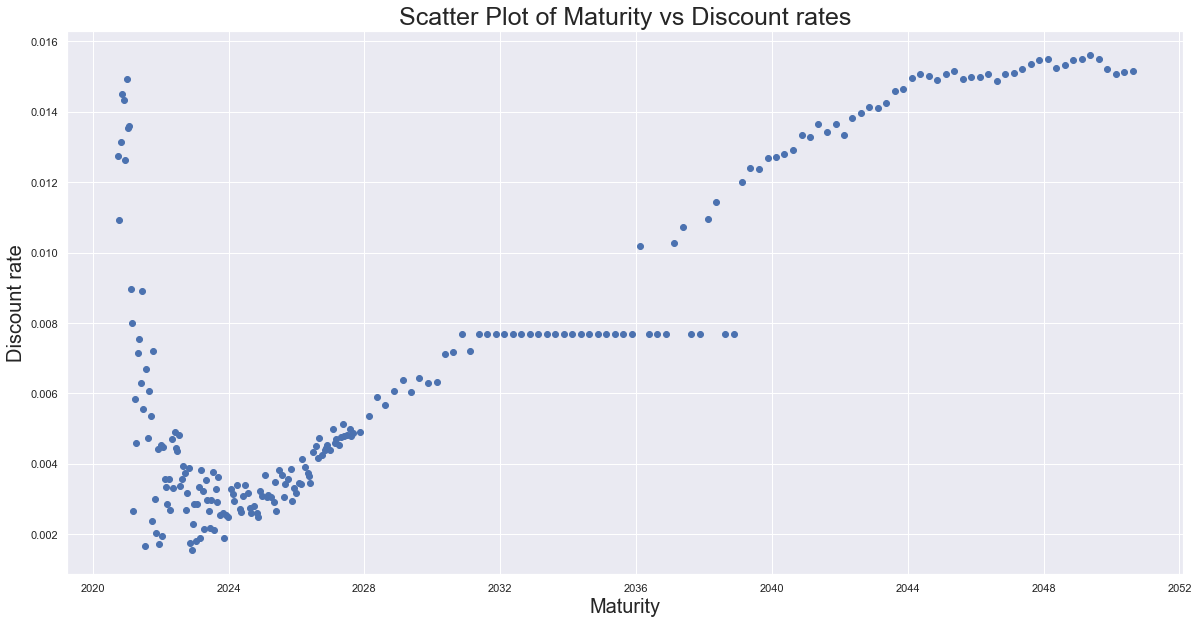

In [39]:
#Scatter plot of dates vs discount rates
plt.figure(figsize=(20,10))
plt.scatter(disc_rates.index,disc_rates.Rates)
plt.title('Scatter Plot of Maturity vs Discount rates', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)

## Removing Outliers

In [41]:
disc_rates_f = disc_rates[disc_rates.Rates < 0.06]
disc_rates_f['Mat_Time'] = (disc_rates_f.index - date0).days/365.25

## Fitting a smooth curve through the spine using Spline and Gaussian Filter

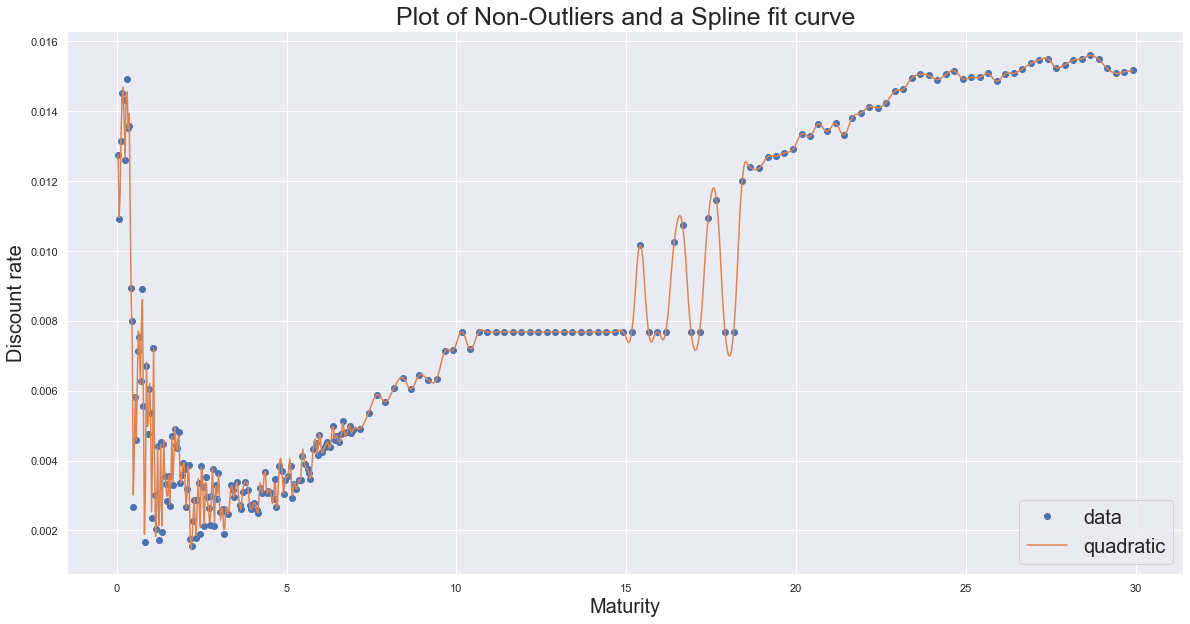

In [42]:
from scipy.interpolate import interp1d
fit = 'quadratic'
f = interp1d(disc_rates_f.Mat_Time, disc_rates_f.Rates, kind = fit)
mat_times_granular = np.linspace(disc_rates_f.Mat_Time.min(), disc_rates_f.Mat_Time.max(), num=1000, endpoint=True)

plt.figure(figsize=(20,10))
plt.title('Plot of Non-Outliers and a Spline fit curve', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)
plt.plot(disc_rates_f.Mat_Time, disc_rates_f.Rates , 'o', mat_times_granular, f(mat_times_granular), '-')
plt.legend(['data', fit], loc='best', prop={'size': 20})


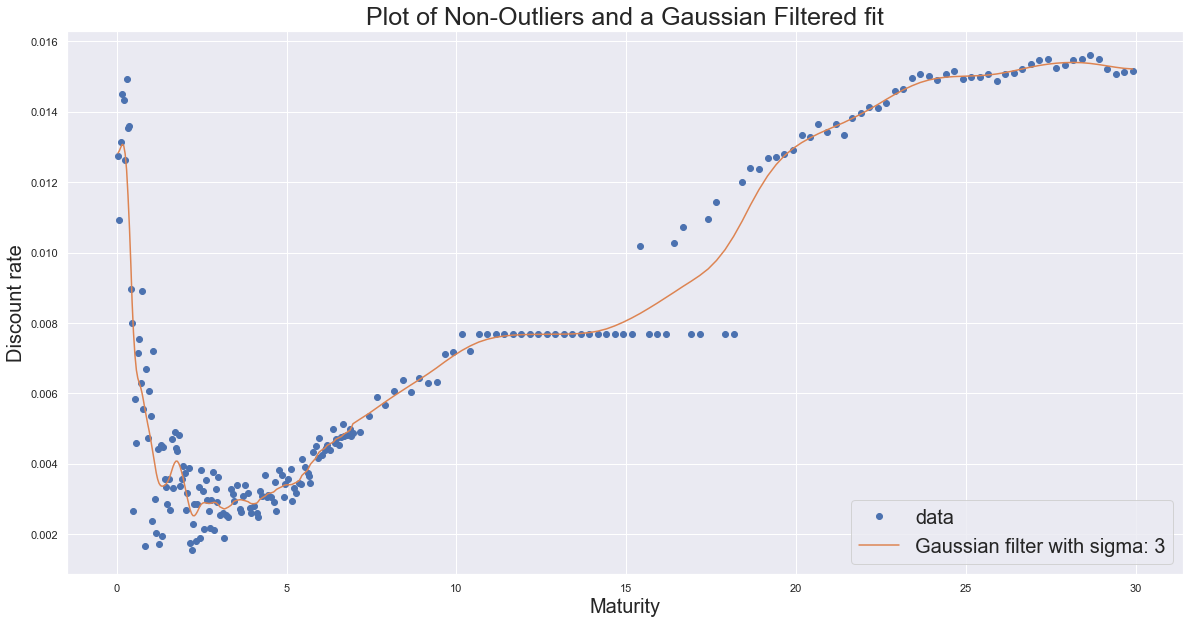

In [43]:
from scipy.ndimage.filters import gaussian_filter1d
sig = 3
rates_smoothg = gaussian_filter1d(disc_rates_f.Rates, sigma = sig)

plt.figure(figsize=(20,10))
plt.title('Plot of Non-Outliers and a Gaussian Filtered fit', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)
plt.plot(disc_rates_f.Mat_Time, disc_rates_f.Rates , 'o', disc_rates_f.Mat_Time, rates_smoothg)
plt.legend(['data','Gaussian filter with sigma: ' + str(sig)], prop={'size': 20})

## Write data to csv

In [44]:
#CF.to_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/CF.csv")
#Price_matrix.to_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/PM.csv")
#disc_rates.to_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/disc.csv")